In [242]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sp-500/SPX Index.csv


In [243]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 12

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [244]:
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

from tensorflow import keras
from tensorflow.keras import layers

Set seed to make accuracy comparable with different timeframes

In [245]:
#from tensorflow.random import set_seed

#set_seed(1234)
#np.random.seed(1234)

Import data and set date as index.

In [246]:
stock = pd.read_csv('../input/sp-500/SPX Index.csv', index_col="DATE_", parse_dates=["DATE_"]
)
stock.head()

,PRICE_CLOSE
DATE_,
1927-12-30,17.66
1928-01-03,17.76
1928-01-04,17.72
1928-01-05,17.55
1928-01-06,17.66


Check to see that there's no empty rows with no data

In [247]:
stock.isna().sum()

PRICE_CLOSE    0
dtype: int64

In [248]:
print(stock.describe())

        PRICE_CLOSE
count  23752.000000
mean     553.333971
std      873.062869
min        4.400000
25%       24.240000
50%      100.710000
75%      920.320000
max     4796.560000


In [249]:
print(stock.shape)

(23752, 1)


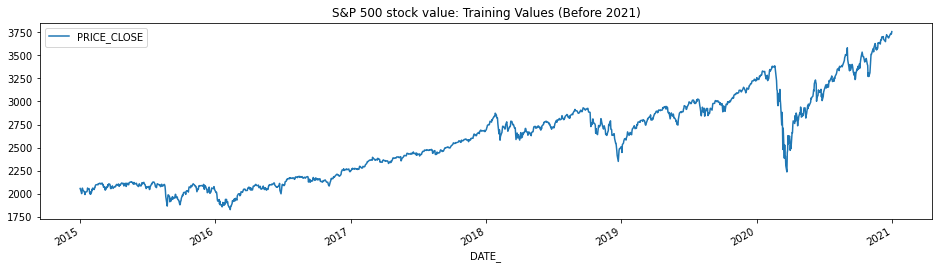

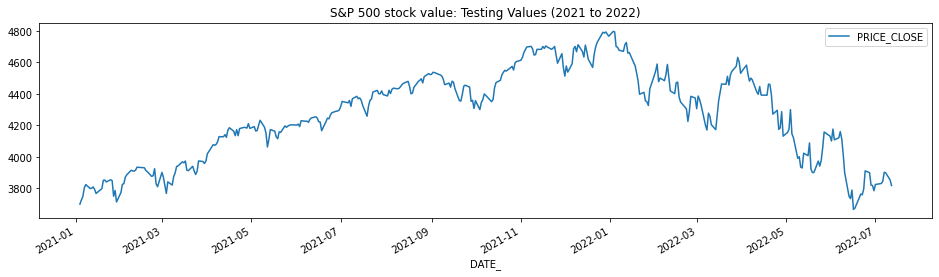

In [266]:
tstart = 2015
tend = 2020

def train_test_plot(stock, tstart, tend):
    stock.loc[f"{tstart}":f"{tend}"].plot(figsize=(16, 4), legend=True)
    plt.title(f"S&P 500 stock value: Training Values (Before {tend+1})")
    stock.loc[f"{tend+1}":f"{tend+2}"].plot(figsize=(16, 4), legend=True)
    plt.title(f"S&P 500 stock value: Testing Values ({tend+1} to {tend+2})")
    plt.show()

train_test_plot(stock,tstart,tend)

In [251]:
def split_test_train(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}"].values
    test = dataset.loc[f"{tend+1}":f"{tend+2}"].values
    return train, test
training_set, test_set = split_test_train(stock, tstart, tend)

Normalize data using StandardScaler

training_set is a numpy array (no longer a pandas dataframe)

In [252]:
sc = StandardScaler()
training_set = sc.fit_transform(training_set.reshape(-1,1))
training_set.view()

array([[-1.15202966],
       [-1.23509049],
       [-1.27476628],
       ...,
       [ 2.53258586],
       [ 2.54362531],
       [ 2.59668091]])

In [253]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X, y = split_sequence(training_set, n_steps) 

In [254]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features) # reshape to fit LSTM Model

In [255]:
model = keras.Sequential ([
    layers.LSTM(units=124, activation='tanh', return_sequences=True, input_shape=(n_steps, features)),
    layers.Dropout(0.2),
    layers.LSTM(units=124, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(units = 1)
])

model.compile(
    optimizer="adam", 
    loss="mse"
)

Implement early stopping to prevent overfitting.

In [256]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=400,
    callbacks=[early_stopping],
)

Epoch 1/400
3/3 [==============================] - 6s 901ms/step - loss: 0.8015 - val_loss: 0.0664
Epoch 2/400
3/3 [==============================] - 2s 476ms/step - loss: 0.0957 - val_loss: 0.1405
Epoch 3/400
3/3 [==============================] - 2s 519ms/step - loss: 0.0999 - val_loss: 0.0444
Epoch 4/400
3/3 [==============================] - 2s 482ms/step - loss: 0.0600 - val_loss: 0.0826
Epoch 5/400
3/3 [==============================] - 2s 478ms/step - loss: 0.0922 - val_loss: 0.0521
Epoch 6/400
3/3 [==============================] - 2s 476ms/step - loss: 0.0497 - val_loss: 0.0292
Epoch 7/400
3/3 [==============================] - 2s 477ms/step - loss: 0.0334 - val_loss: 0.0550
Epoch 8/400
3/3 [==============================] - 2s 467ms/step - loss: 0.0493 - val_loss: 0.0334
Epoch 9/400
3/3 [==============================] - 2s 479ms/step - loss: 0.0289 - val_loss: 0.0261
Epoch 10/400
3/3 [==============================] - 2s 511ms/step - loss: 0.0296 - val_loss: 0.0310
Epoch 11/

Evaluate training

Minimum Validation Loss: 0.0101


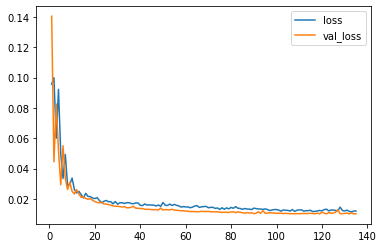

In [257]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot();
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [258]:
dataset_total = stock.loc[:f"{tend+2}"]

In [259]:
#dataset_total = stock.loc[:]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [260]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("S&P 500 Index Value Prediction")
    plt.xlabel("Time")
    plt.ylabel("S&P 500 Index Value")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

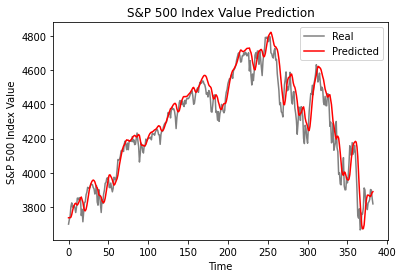

In [261]:
plot_predictions(test_set,predicted_stock_price)

In [262]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 76.49.


Generally mean squared error (MSE) is used to train models while root mean squared error is used to evalute its accuracy.

The root mean squared error (RMSE) is very good considering that the range is high.

In [267]:
print(f"Values from {tend+1} to {tend+2}")
print(stock.loc[f"{tend+1}":f"{tend+2}"].describe())

Values from 2021 to 2022
       PRICE_CLOSE
count   383.000000
mean   4269.414883
std     285.732516
min    3666.770000
25%    4040.865000
50%    4306.260000
75%    4483.300000
max    4796.560000


I attempt to normalize the RMSE using the range.

$NRMSE = \frac{RMSE}{y_{max}-y_{min}}$

In [268]:
normalized =  np.sqrt(mean_squared_error(test_set,predicted_stock_price)) / (stock.loc[f"{tend+1}":f"{tend+2}"].max(axis=0)-stock.loc[f"{tend+1}":f"{tend+2}"].min(axis=0))
print(normalized)

PRICE_CLOSE    0.067704
dtype: float64


In [265]:
model.save("rnn_s_p_500.h5")